This file is to try SBI_SGMFC 

And I train model with a general connectome.


# import and define

In [1]:
import sys
sys.path.append("../mypkg")

In [2]:
import torch
import numpy as np
import xarray as xr
import scipy

import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial

In [3]:
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

In [5]:
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT
from spectrome import Brain
from sgm.sgmfc import SGMFC
from sbi_sgm_fc import SBI_SGMFC
from utils.misc import load_pkl

# Load real data PSD and brain

In [8]:
empfc = load_pkl(DATA_ROOT/"example_fc.pkl");
brain = Brain.Brain()
brain.add_connectome(DATA_ROOT) # grabs distance matrix
# re-ordering for DK atlas and normalizing the connectomes:
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.bi_symmetric_c()
brain.reduce_extreme_dir()

# th sgmfc class
C = brain.reducedConnectome
D = brain.distance_matrix
sgmfcmodel = SGMFC(C, D, freqs="theta")
#sgmfcmodel = SGMFC(C, D, freqs=[12, 13, 14])

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM_clean/notebooks/../mypkg/../data/example_fc.pkl


# SBI-SGMFC class

In [9]:
# initial the SBI_SGMFC class
# sgmmodel: SGMFC class.
# save_folder: the folder you want to save the results to, str or bool, if True, it generates a default folder
# verbose: more output or not. if you feel the output info is annoying, set verbose=False
# num_prior_sps: the num of sps used to train SBI
# noise_sd: the noise sd added to SGM output 
# num_round: the num of rounds to train SBI, if num_round > 1, you should add data first
# (num_prior_sps, noise_sd, num_round) are most inferential params in SBI_SGMFC
# other params for fitting sbi, refer to source file

#TODO: in the inference, it can also support using annealing to find a good prior for SBI
sbi_sgmfc = SBI_SGMFC(sgmfcmodel=sgmfcmodel, save_folder="test_sbisgmfc", verbose=True,
                      input_params={"num_prior_sps":500, "noise_sd":1.2, "num_round":3});


2024-02-14 15:43:28,822 - sbi_sgm_fc - INFO - In this class, the sgm parameter order is ['TauC', 'Speed', 'alpha'].
2024-02-14 15:43:28,823 - sbi_sgm_fc - INFO - {'noise_sd': 1.2, 'num_prior_sps': 500, 'den_est': 'nsf', 'prior_sd': 1, 'k': 1, 'num_round': 3, 'names': ['TauC', 'Speed', 'alpha'], 'prior_bds': array([[5.0e-03, 3.0e-02],
       [5.0e+00, 2.0e+01],
       [1.0e-01, 1.7e+01]])}
2024-02-14 15:43:28,828 - sbi_sgm_fc - INFO - Results will be saved at /data/rajlab1/user_data/jin/MyResearch/SBI-SGM_clean/notebooks/../mypkg/../results/test_sbisgmfc.


In [10]:
# you add the fc data for inference
# note that when fitting, we do not use diag terms for fc.
#TODO: in the future, it will also support to import raw MEG time series data directly.
sbi_sgmfc.add_data(fc=empfc)

In [11]:
# now you can fit the model
# load: if you have saved results, you can set load = true to load it
sbi_sgmfc.SBI_fit(load=True)

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM_clean/notebooks/../mypkg/../results/test_sbisgmfc/posterior.pkl


In [12]:
# Get the posterior samples of SGMFC params
# n: num of sps to draw
sgm_parmas_sps = sbi_sgmfc.get_post_sps(n=1000);

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/hujin/.local/lib/python3.9/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2189.)
  outputs, _ = torch.triangular_solve(


In [13]:
# based on generated sgm parameters, get modeled fc
# note that the modelled fc is minmaxed
estfc = sbi_sgmfc.get_model_fc();

The Pearson's corr is 0.232


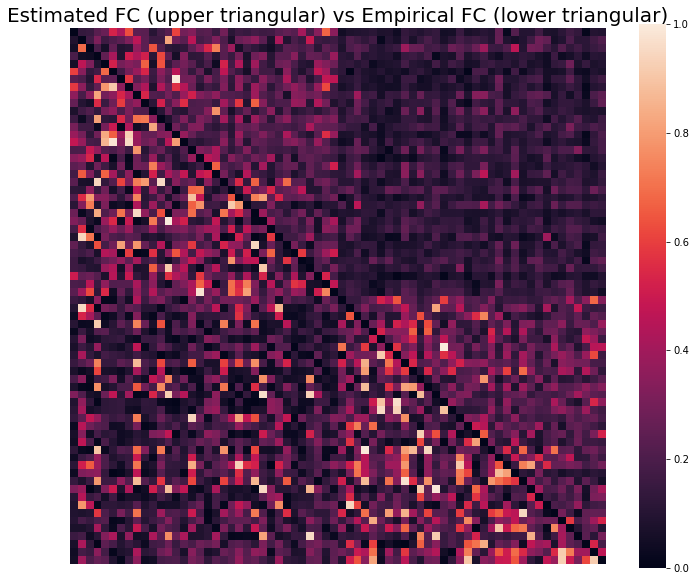

In [14]:
# let us compare the fitted and the empirical ones
_, estvec = sbi_sgmfc.get_stdfc(estfc)
std_empfc, empvec = sbi_sgmfc.get_stdfc(empfc);
corr = scipy.stats.pearsonr(estvec, empvec)[0];

mat = np.zeros_like(estfc)
uidxs = np.triu_indices_from(estfc, k=1)
lidxs = np.tril_indices_from(estfc, k=1)
mat[lidxs] = std_empfc[lidxs]
mat[uidxs] = estfc[uidxs]

plt.figure(figsize=[12, 10])
plt.title(f"Estimated FC (upper triangular) vs Empirical FC (lower triangular)", fontsize=20)
sns.heatmap(mat, square=True)
plt.xticks([])
plt.yticks([]);
print(f"The Pearson's corr is {corr:.3f}");